In [1]:
!pip install torchview

In [2]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import numpy as np
import os
import time
import graphviz
from torchview import draw_graph
from matplotlib import pyplot as plt

# 1. Загрузка данных

In [4]:
dir_name = os.getcwd()
norm_params = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
batch_size = 256

Выполним предобработку тренировочных данных:   
*   нормализация данных по каналам;
*   случайный горизонтальный переворот;
*   обрезка изображения в случайном месте с дополнениям по всем границам;


In [5]:
train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*norm_params, inplace=True)
    ]
)

transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(*norm_params)
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = train_transforms
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = transforms
)

100%|██████████| 170498071/170498071 [00:12<00:00, 13126024.54it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [6]:
name_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("Class names: {}".format(name_classes))

Class names: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


In [7]:
def denormal(image, means, stds):
    means = torch.tensor(means).reshape(3, 1, 1)
    stds = torch.tensor(stds).reshape(3, 1, 1)
    return image * stds + means

def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plt.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plt.setp(plt.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = denormal(images[i][0], *norm_params)
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow((img * 255).astype('uint8'))

Визуально отобразим несколько примеров из тернировочных и тестовых данных.

Number of train samples: 50000
Number of test samples: 10000


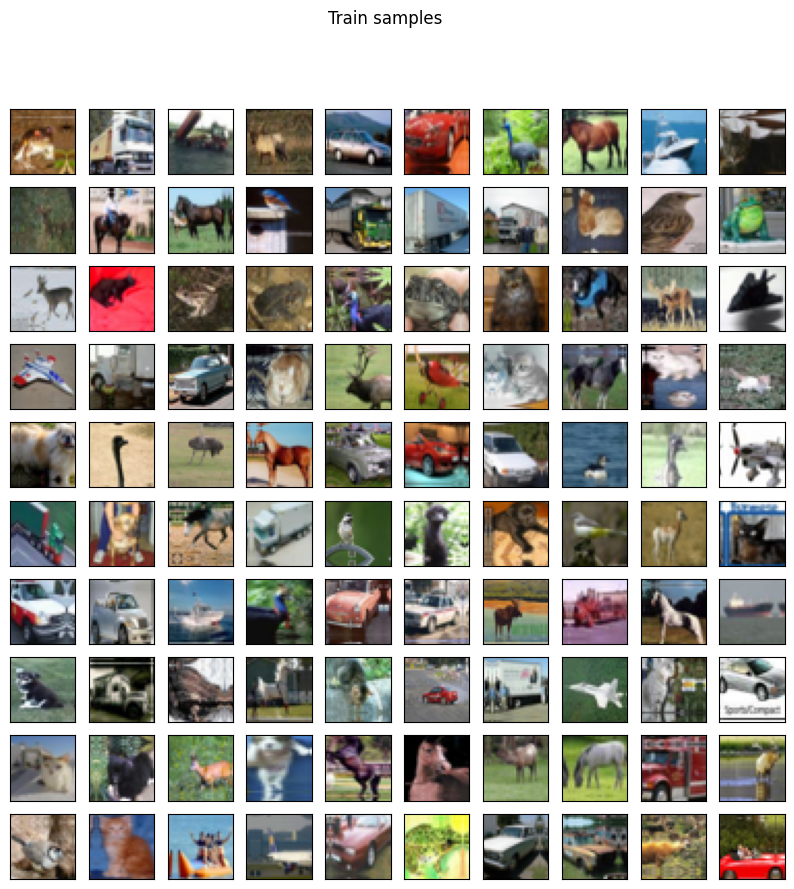

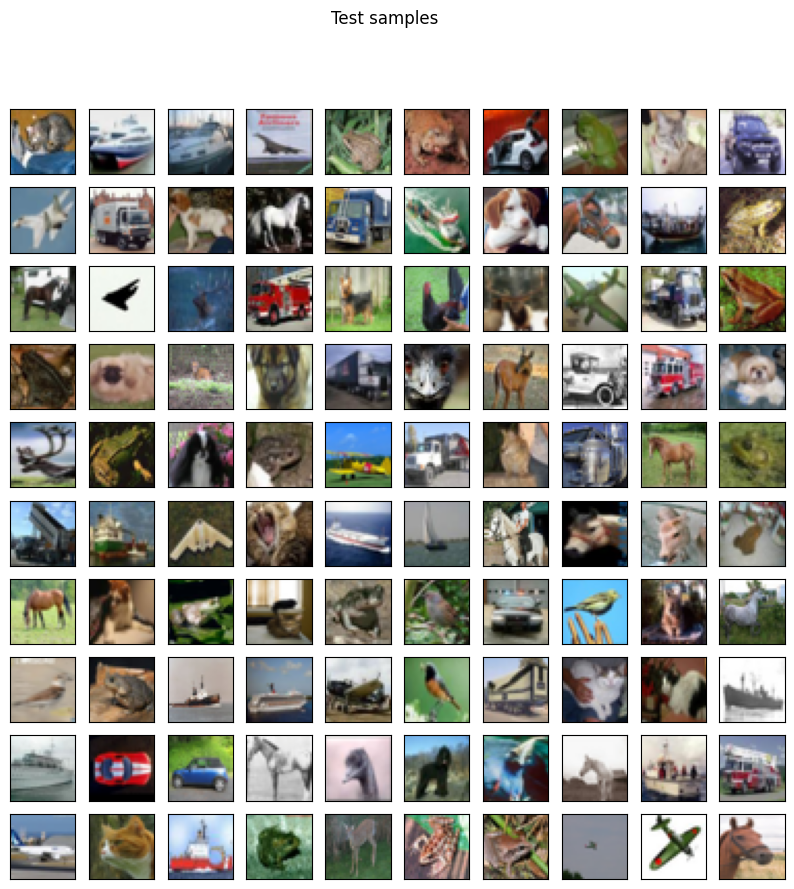

In [8]:
print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, 'Train samples')

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, 'Test samples')

In [9]:
def shape_input(dataset):
  N = len(dataset)
  channels, h, w = dataset[0][0].numpy().shape
  return '({}, {}, {}, {})'.format(N, channels, h, w)

def shape_output(dataset):
  N = len(dataset)
  return '({}, 1)'.format(N)

In [10]:
print('Размерность входных данных тренировочной выборки: {}'.format(shape_input(train_dataset)))
print('Размерность входных данных тестовой выборки: {}'.format(shape_input(test_dataset)))
print()
print('Размерность ответов тренировочной выборки: {}'.format(shape_output(train_dataset)))
print('Размерность ответов тестовой выборки: {}'.format(shape_output(test_dataset)))
print()
print('Тип входных данных {}'.format(train_dataset[0][0].numpy().dtype))

Размерность входных данных тренировочной выборки: (50000, 3, 32, 32)
Размерность входных данных тестовой выборки: (10000, 3, 32, 32)

Размерность ответов тренировочной выборки: (50000, 1)
Размерность ответов тестовой выборки: (10000, 1)

Тип входных данных float32


Приведем несколько примеров с метками.

In [11]:
def view_image(image, title):
  img = denormal(image[0], *norm_params)
  img = img.numpy().transpose(1, 2, 0)
  figsize = (10, 10)
  plt.title("{}: {}".format(title, name_classes[image[1]]))
  plt.imshow((img * 255).astype('uint8'))

Label: 3


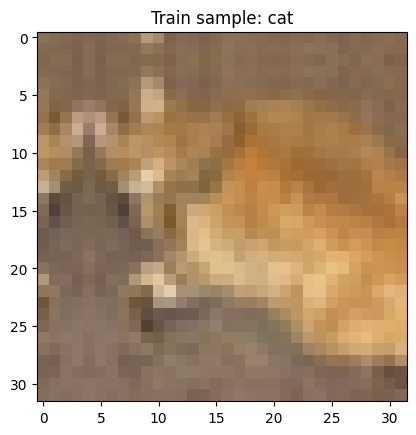

In [12]:
ind = 141
view_image(train_dataset[ind], 'Train sample')
print('Label: {}'.format(train_dataset[ind][1]))

Label: 2


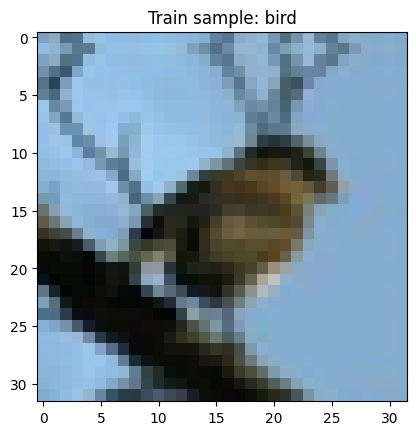

In [13]:
ind = 8888
view_image(train_dataset[ind], 'Train sample')
print('Label: {}'.format(train_dataset[ind][1]))

In [14]:
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

# 2. Построение архитектуры сверточной сети

Будем строить сверточную нейронную сеть архитектуры ResNet.

In [15]:
def blocks(in_channels, out_channels):
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        torch.nn.BatchNorm2d(out_channels),
        torch.nn.ReLU(inplace=True)
    )

In [29]:
class ResNet9(torch.nn.Module):
  def __init__(self):
      super(ResNet9, self).__init__()
      self.conv1 = blocks(3, 64)
      self.conv_and_pool_1 = torch.nn.Sequential(
          blocks(64, 128),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.res1 = torch.nn.Sequential(
          blocks(128, 128),
          blocks(128, 128)
      )
      self.conv_and_pool_2 = torch.nn.Sequential(
          blocks(128, 256),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.conv_and_pool_3 = torch.nn.Sequential(
          blocks(256, 512),
          torch.nn.MaxPool2d(kernel_size=2)
      )
      self.res2 = torch.nn.Sequential(
          blocks(512, 512),
          blocks(512, 512)
      )
      self.final_pool = torch.nn.MaxPool2d(kernel_size=4)
      self.dense = torch.nn.Sequential(
          torch.nn.Flatten(),
          torch.nn.Dropout(0.2),
          torch.nn.Linear(512, 10)
      )

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv_and_pool_1(out)
    out = self.res1(out) + out
    out = self.conv_and_pool_2(out)
    out = self.conv_and_pool_3(out)
    out = self.res2(out) + out
    out = self.final_pool(out)
    out = self.dense(out)
    return out

Выведем информацию об архитектуре.

In [30]:
cnn_model = ResNet9()
cnn_model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_and_pool_1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_run

Визуализируем сеть.

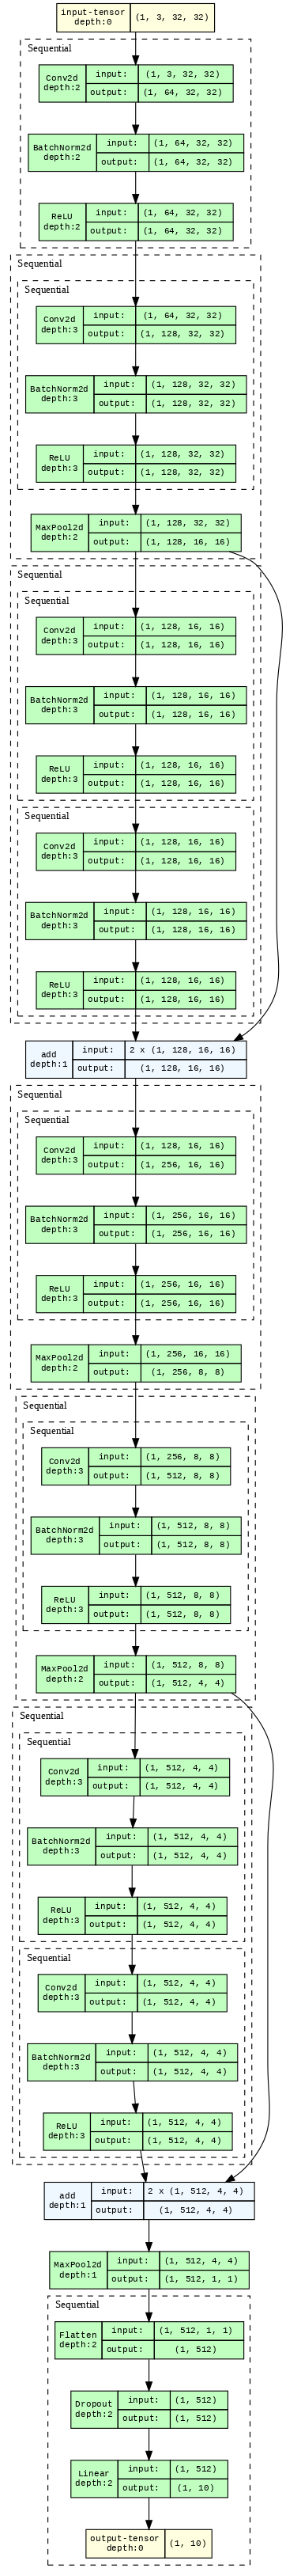

In [31]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(cnn_model, input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

# 3 Обучение модели

In [32]:
learning_rate = 0.001
num_epochs = 25

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr = learning_rate)

In [33]:
def get_accuracy(model, data_loader, device):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

def get_loss(model, data_loader, device):
    loss = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            loss += loss_function(outputs, labels)
            n += labels.size(0)
    return loss / n

def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

def epoch_acc(accuracies):
  return torch.stack(accuracies).mean()

def epoch_loss(losses):
  return torch.stack(losses).mean()

In [34]:
def train(cnn_model, data_loader, epochs, loss_function, optimizer, device):
  start_time = time.time()
  for epoch in range(epochs):
    start_epoch = time.time()
    accuracies = []
    losses = []
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = cnn_model(images)
        loss = loss_function(outputs, labels)
        acc = accuracy(outputs, labels)

        losses.append(loss)
        accuracies.append(acc)

        loss.backward()
        optimizer.step()
    total_time_epoch = time.time() - start_epoch
    print('Epoch[{}]: Loss = {:.4f}, Train accuracy = {:.4f}, Time epoch = {:.4f}'.
          format(epoch + 1,
                 epoch_loss(losses),
                 epoch_acc(accuracies),
                 total_time_epoch))
  total_time = time.time() - start_time
  print('Total time {}'.format(total_time))

In [35]:
train(cnn_model, train_data_loader, num_epochs, loss_function, optimizer, device)

Epoch[1]: Loss = 1.4787, Train accuracy = 0.4836, Time epoch = 39.3760
Epoch[2]: Loss = 0.9245, Train accuracy = 0.6765, Time epoch = 39.0553
Epoch[3]: Loss = 0.7173, Train accuracy = 0.7482, Time epoch = 39.4326
Epoch[4]: Loss = 0.5997, Train accuracy = 0.7923, Time epoch = 38.5788
Epoch[5]: Loss = 0.5285, Train accuracy = 0.8179, Time epoch = 38.3394
Epoch[6]: Loss = 0.4721, Train accuracy = 0.8373, Time epoch = 37.8928
Epoch[7]: Loss = 0.4293, Train accuracy = 0.8524, Time epoch = 37.9782
Epoch[8]: Loss = 0.3833, Train accuracy = 0.8675, Time epoch = 37.9774
Epoch[9]: Loss = 0.3524, Train accuracy = 0.8774, Time epoch = 37.8628
Epoch[10]: Loss = 0.3259, Train accuracy = 0.8883, Time epoch = 38.1807
Epoch[11]: Loss = 0.3009, Train accuracy = 0.8961, Time epoch = 38.0809
Epoch[12]: Loss = 0.2824, Train accuracy = 0.9021, Time epoch = 38.5217
Epoch[13]: Loss = 0.2615, Train accuracy = 0.9097, Time epoch = 38.1696
Epoch[14]: Loss = 0.2345, Train accuracy = 0.9187, Time epoch = 37.8744
E

# 4. Тестирование модели

In [36]:
print('Loss = {:.4f}, Test accuracy = {:.4f}'.format(
    get_loss(cnn_model, test_data_loader, device),
    get_accuracy(cnn_model, test_data_loader, device)))

Loss = 0.0014, Test accuracy = 0.9106


# Приложение
Код для сохранения и загрузки модели.

In [ ]:
torch.save(cnn_model.state_dict(), 'cnnModel.pth')
cnn_model.load_state_dict(torch.load('cnnModel.pth'))

Загрузка на CPU.

In [ ]:
cnn_model.load_state_dict(torch.load('cnnModel.pth', map_location=torch.device('cpu')))

<All keys matched successfully>